# Prework

In [1]:
import sys
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
import statsmodels.api as sm
from math import sqrt as math_sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import pickle
import math
import random
import matplotlib.dates as mdates

#Import custom modules
sys.path.append('../')
from utils.utils import *

sns.set_theme(style="whitegrid")

In [2]:
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 2.4.1
Eager execution: True


## Load data

In [3]:
training_data, testing_data, testing_index = load_data()
countries, no_features, _ , years, months, weekdays, hours = load_data_information()

In [4]:
country_dict, feature_dict = get_dictionaries()
feature_names = list(feature_dict.keys())
country_names = list(country_dict.keys())
country_dict_reversed = {value : key for (key, value) in country_dict.items()}
feature_dict_reversed = {value : key for (key, value) in feature_dict.items()}

In [5]:
with open("../data/data_normalization.pkl", "rb") as p:
    mean, sd = pickle.load(p)

In [6]:
# Extracts features, year, etc. from whole data
def change_format(input_data):
    #Extract year from data matrix
    year_w = input_data[:,:,0:1]
    #Extract weekday from data matrix
    weekday_w = input_data[:,:,1:2]
    #Extract hour from data matrix
    hour_w = input_data[:,:,2:3]
    #Extract country from data matrix
    country_w = input_data[:,0:1,3]   
    #Extract month from data matrix
    month_w = input_data[:,:,4:5]
    #Extract features from matrix
    features_w = input_data[:,:,5:5+no_features]
    #Extract matrix of missing values from data matrix
    miss_vals_w = input_data[:,:,-no_features-6:-6]
    #Extract pos enc from data matrix
    pos_enc_w = input_data[:,:,-6:]


    #Prepare format for features
    features_tf = np.reshape(features_w, [features_w.shape[0], -1, 1])
    miss_vals_tf = np.reshape(miss_vals_w, [features_w.shape[0], -1, 1])
    pos_enc_tf = np.reshape(tf.transpose(np.repeat(np.reshape(pos_enc_w, [pos_enc_w.shape[0], pos_enc_w.shape[1], pos_enc_w.shape[2], 1]),
                                                   no_features, axis = 3), perm=[0,1,3,2]),[pos_enc_w.shape[0],-1,pos_enc_w.shape[2]])
    feature_nr_tf = np.repeat(np.reshape(np.repeat(np.reshape(np.array(range(no_features)),[1,-1]), input_data.shape[1], axis = 0),[1,-1]), input_data.shape[0], axis = 0)
    
    #Reshape other features
    hour_tf = np.reshape(np.repeat(hour_w, no_features,axis=2),[input_data.shape[0],-1])
    year_tf = np.reshape(np.repeat(year_w, no_features,axis=2),[input_data.shape[0],-1])
    weekday_tf = np.reshape(np.repeat(weekday_w, no_features,axis=2),[input_data.shape[0],-1])
    month_tf = np.reshape(np.repeat(month_w, no_features,axis=2),[input_data.shape[0],-1])
    
    

    return features_tf, miss_vals_tf, pos_enc_tf, country_w, year_tf, weekday_tf, hour_tf, feature_nr_tf

In [7]:
def mask_features(features, miss_vals, prob_mask):
    #Create and eshape mask
    realized_mask = np.zeros(shape = (prob_mask.shape[0], 5 * 24* no_features))
    realized_mask[:,2*24*no_features:3*24*no_features] = np.squeeze(np.random.binomial(1, prob_mask))
    realized_mask = realized_mask.reshape(features.shape)

    #Mask features
    features_masked = np.array(features)
    features_masked[realized_mask == 1] = 0
    #Mask missing values
    miss_vals_masked = np.array(miss_vals)
    miss_vals_masked[realized_mask == 1] = 1

    return features_masked, miss_vals_masked, realized_mask, miss_vals

In [8]:
metrics = ["MSE", "MAE"]
models = ["transformer","lstm", "locf", "knn"]
methods = [x+"_pred" for x in ["transformer","lstm", "locf", "knn"]]

# Load predictions for full distribution

In [9]:
features, miss_vals, pos_enc, country, year, weekday, hour, feature_nr = change_format(testing_data)
testing_mask = np.load("../data/evaluation/testing_distribution_full.npy")
features_masked, miss_vals_masked, mask, miss_vals = mask_features(features, miss_vals, testing_mask)

#Obtain missing and true values
missing = miss_vals[mask == 1]
true_values = features[mask == 1][missing == 0]

In [10]:
results = pd.DataFrame(columns = models, index = pd.MultiIndex.from_product([metrics,["Mean","SD"]]))
for model in models:
    #Load prediction
    pred = np.load("../data/predictions/{}_pred_full.npy".format(model))
    #Remove missing values
    pred = pred[missing == 0]
    #Calculate error and metrics
    error = pred - true_values
    squared = np.square(error)
    absolute = np.abs(error)
    #Save to results
    results.loc[("MSE", "Mean"), model] = np.round(squared.mean(),4)
    results.loc[("MSE", "SD"), model] = np.round(squared.std(),4)
    results.loc[("MAE", "Mean"), model] = np.round(absolute.mean(),4)
    results.loc[("MAE", "SD"), model] = np.round(absolute.std(),4)

In [11]:
results

transformer    lstm    locf     knn
MSE Mean      0.0573  0.0604  0.1016  0.0567
    SD        0.6785  0.4243  0.8809  0.4785
MAE Mean      0.0849  0.1189  0.0993  0.0883
    SD        0.2238   0.215  0.3028  0.2212

# Load predictions for filtered distribution

In [37]:
features, miss_vals, pos_enc, country, year, weekday, hour, feature_nr = change_format(testing_data)
testing_mask = np.load("../data/evaluation/testing_distribution_filtered.npy")
features_masked, miss_vals_masked, mask, miss_vals = mask_features(features, miss_vals, testing_mask)

#Obtain missing and true values
missing = miss_vals[mask == 1]
true_values = features[mask == 1][missing == 0]

In [41]:
results = pd.DataFrame(columns = models, index = pd.MultiIndex.from_product([metrics,["Mean","SD"]]))
for model in models:
    #Load prediction
    pred = np.load("../data/predictions/{}_pred_filtered.npy".format(model))
    #Remove missing values
    pred = pred[missing == 0]
    #Calculate error and metrics
    error = pred - true_values
    squared = np.square(error)
    absolute = np.abs(error)
    #Save to results
    results.loc[("MSE", "Mean"), model] = np.round(squared.mean(),4)
    results.loc[("MSE", "SD"), model] = np.round(squared.std(),4)
    results.loc[("MAE", "Mean"), model] = np.round(absolute.mean(),4)
    results.loc[("MAE", "SD"), model] = np.round(absolute.std(),4) 

Model: 0.0003740255540449766
Model: 0.0028832771209330588
Model: 4.739718406199245e-06
Model: 0.0001594458444742486


In [39]:
results

transformer    lstm    locf     knn
MSE Mean       0.061  0.0687   0.103  0.0668
    SD        0.5822   0.581  0.9196  0.5645
MAE Mean      0.0845  0.1217  0.0959  0.0927
    SD        0.2321   0.232  0.3062  0.2412

## Create information matrix for predictions

In [35]:
#Zieht die Informationen aus dem Testdatensatz
features, miss_vals, pos_enc, country, year, weekday, hour, feature_nr = change_format(testing_data)
testing_mask = np.load("../data/evaluation/testing_distribution_filtered.npy")
features_masked, miss_vals_masked, mask, miss_vals = mask_features(features, miss_vals, testing_mask)
length = 120

In [36]:
#Informationen über true values
true_values_inf = features[mask==1]

#Informationen über die Reihenfolge der Features
feature_number_inf = feature_nr.reshape(feature_nr.shape[0],feature_nr.shape[1],1)[mask==1]

#Informationen über die Länder
country_inf = np.repeat(country,no_features*length,axis=1).reshape(country.shape[0],no_features*length,1)[mask==1]

#Informationen über die Zeitreihe
time_index_reshaped = np.repeat(testing_index.reshape(testing_index.shape[0],testing_index.shape[1],1),no_features,axis=2)
time_index_inf = time_index_reshaped.reshape(testing_index.shape[0],no_features*length,1)[mask==1]

#Informationen über die Sample (Tages-) nummer
sample_inf = np.repeat(np.arange(testing_data.shape[0]).reshape(testing_data.shape[0],1),no_features*length,axis=1).reshape(testing_data.shape[0],no_features*length,1)[mask==1]

# Informationen in einem Dataframe sammeln
information_concat = np.concatenate((time_index_inf, sample_inf, country_inf,feature_number_inf, true_values_inf),axis=0).reshape(-1,true_values_inf.shape[0])

#Save to dataframe
results = pd.DataFrame(information_concat[1:].transpose(), index = information_concat[0], columns = [
    "Sample","Country", "Feature", "True value"])
results["Country"]=results["Country"].astype("int")
results["True value"] = pd.to_numeric(results["True value"])
results["Feature"] = results["Feature"].map(feature_dict_reversed)

#Append predictions
for model in models:
    #Load prediction
    pred = np.load("../data/predictions/{}_pred_filtered.npy".format(model))
    results[model] = pred
    results[model+"_error"] = pred - true_values_inf
    
    
#Count missing values
perc_missing = results.groupby("Feature").count()["Sample"]/(features.shape[0]*24)*100

#Remove missing values
results = results[missing == 0]

## Error per feature

### MSE

In [17]:
columns = [model+"_error" for model in models]
results_mse = results[columns].pow(2)
results_mse["Feature"] = results["Feature"]
results_mse = results_mse.groupby("Feature").mean()
#Add Missing percentage
results_mse.insert(0,"Perc Missing",perc_missing)
results_mse = results_mse.round(4)
results_mse["Perc Missing"] = results_mse["Perc Missing"].round(2)
results_mse.sort_values(by = "Perc Missing", ascending = False, inplace = True)
results_mse.to_excel("mse_per_feature.xlsx")

In [18]:
results_mse

,Perc Missing,transformer_error,lstm_error,locf_error,knn_error
Feature,,,,,
Hard coal,23.00,0.0222,0.0291,0.0369,0.0380
Other,21.46,0.0108,0.0209,0.0209,0.0169
Pumped Storage,16.93,0.1662,0.1785,0.3110,0.1929
Fossil Gas,16.11,0.0636,0.0607,0.1150,0.0719
PV,10.45,0.0778,0.0990,0.0660,0.0662
Hydro,9.49,0.0194,0.0527,0.0237,0.0268
Biomass,5.97,0.0110,0.0343,0.0144,0.0160
Day_ahead_price,5.00,0.1012,0.0942,0.1865,0.0957
Wind Offshore,4.14,0.2103,0.1429,0.3651,0.1311


## Error in dependence of amount of missing values

In [19]:
model = "transformer_error"
amount_missing = mask.reshape((mask.shape[0],120,no_features))[:,2*24:3*24].sum(axis = (1,2))
results_missing = results[["Sample", model]].copy()
results_missing.loc[:,model] = results_missing.loc[:,model].pow(2)
results_missing = results_missing.groupby("Sample").mean()
results_missing = results_missing.merge(pd.DataFrame(amount_missing), left_index = True, right_index = True)
results_missing.rename({0:"Amount missing"}, axis = 1, inplace = True)

<AxesSubplot:xlabel='Amount missing', ylabel='transformer_error'>

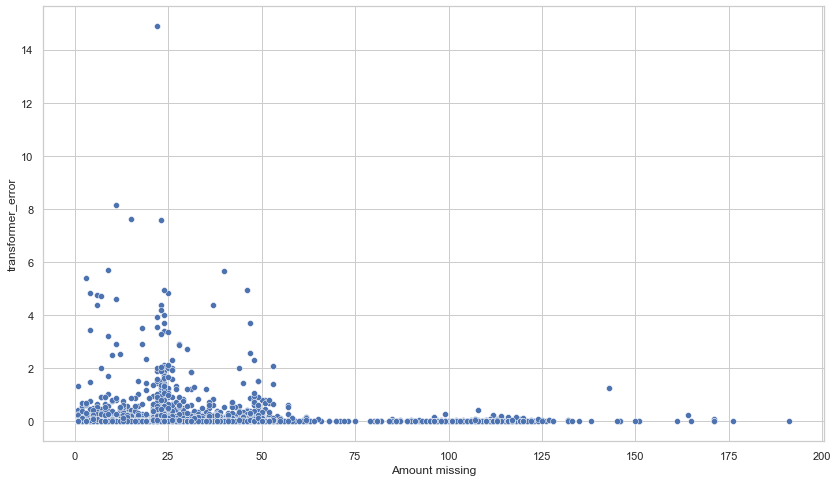

In [23]:
fig, axs = plt.subplots(figsize=(14,8))
sns.scatterplot(y = model, x = "Amount missing", data = results_missing)

In [37]:
results

,Sample,Country,Feature,True value,transformer,transformer_error,lstm,lstm_error,locf,locf_error,knn,knn_error
2016-05-03 00:00:00+00:00,0,5,Lignite,5.142765,4.865558,-0.277206,4.432135,-0.710629,4.997495,-0.145270,4.670815,-0.471949
2016-05-03 01:00:00+00:00,0,5,Lignite,5.115128,4.879703,-0.235425,4.729101,-0.386026,4.966315,-0.148813,4.697531,-0.417597
2016-05-03 02:00:00+00:00,0,5,Lignite,5.134261,4.912122,-0.222138,4.994591,-0.139669,5.114065,-0.020196,4.688106,-0.446155
2016-05-03 03:00:00+00:00,0,5,Lignite,5.147370,4.972068,-0.175303,5.320856,0.173485,5.182448,0.035078,4.690657,-0.456713
2016-05-03 04:00:00+00:00,0,5,Lignite,5.180322,5.018884,-0.161438,5.667155,0.486833,5.273507,0.093185,4.706956,-0.473366
...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-29 17:00:00+00:00,7782,17,Hard coal,-0.029799,-0.139890,-0.110090,-0.065355,-0.035556,-0.045697,-0.015897,-0.073924,-0.044124
2016-05-29 18:00:00+00:00,7782,17,Hard coal,-0.020881,-0.120570,-0.099688,-0.067374,-0.046493,-0.049186,-0.028305,-0.066169,-0.045288
2016-05-29 19:00:00+00:00,7782,17,Hard coal,-0.036391,-0.110745,-0.074354,-0.089972,-0.053581,-0.035228,0.001163,-0.059733,-0.023342
2016-05-29 20:00:00+00:00,7782,17,Hard coal,-0.084470,-0.123187,-0.038717,-0.115806,-0.031336,-0.115101,-0.030631,-0.065704,0.018766


# Load predictions over several masks

In [24]:
multi_index = [np.round(np.arange(0.1,1,0.1),1),metrics]
results = pd.DataFrame(columns=models, index = pd.MultiIndex.from_product(multi_index, names=["Percentage", "Metric"]))
perc = np.round(np.arange(0.1,1,0.1),1)

for p in perc:
    #Load testing mask
    testing_mask = np.load("../evaluation/masks/testing_mask_{}.npy".format(p))

    #Obtain true values
    features, miss_vals, pos_enc, country, year, weekday, hour, feature_nr = change_format(testing_data)
    features_masked, miss_vals_masked, mask = get_testing_mask(features, miss_vals, testing_mask)
    true_values = features[mask==1]

    #Load model predictions
    for model in models:
        prediction = np.load("../data/predictions/{}_pred_{}.npy".format(model,p))

        #Calculate mse
        mse = np.round(mean_squared_error(true_values,prediction),6)
        mae = np.round(mean_absolute_error(true_values,prediction),6)
        mape = np.round(mean_absolute_percentage_error(true_values, prediction),6)

        #Save mse to results
        results.loc[(p,"MSE"),model]=mse
        results.loc[(p,"MAE"),model]=mae
        results.loc[(p,"MAPE"), model] = mape

FileNotFoundError: [Errno 2] No such file or directory: '../evaluation/masks/testing_mask_0.1.npy'

In [ ]:
results

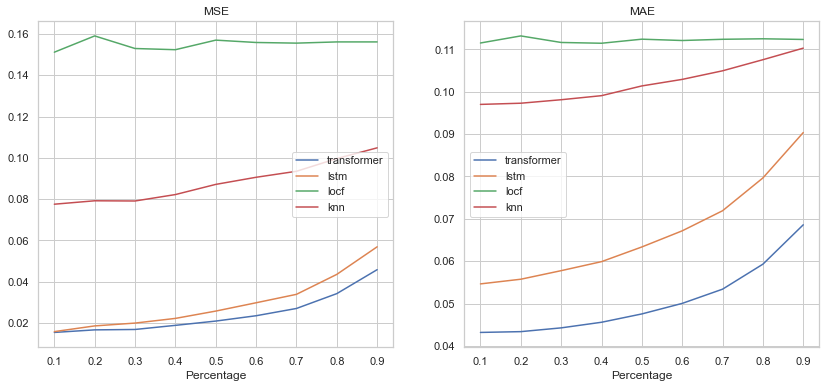

In [155]:
fig, axs = plt.subplots(1,2,figsize=(14,6))
results.loc[(slice(None),"MSE"),:].reset_index().drop("Metric",axis=1).set_index("Percentage").plot(ax = axs[0])
axs[0].set_title("MSE")
results.loc[(slice(None),"MAE"),:].reset_index().drop("Metric",axis=1).set_index("Percentage").plot(ax = axs[1])
axs[1].set_title("MAE")
#results.loc[(slice(None),"MAPE"),:].reset_index().drop("Metric",axis=1).set_index("Percentage").plot(ax = axs[2])
#axs[2].set_title("MAPE")
plt.savefig("../plots/metrics.pdf", dpi = 300, bbox_inches = "tight")

# Create evaluation scheme
Obtain a matrix with true values and information about each prediction in order to make full evaluation

In [28]:
def get_information_matrix(p, testing_data = testing_data, length = 120):
    if p == "estimated":
        testing_mask_raw = np.load("../evaluation/masks/testing_mask_estimated.npy")
        testing_mask = np.zeros(shape = (testing_mask_raw.shape[0],120,no_features))
        testing_mask[:,2*24:3*24] = testing_mask_raw
    else:        
        testing_mask = np.load("../evaluation/masks/testing_mask_{}.npy".format(p))
    #Zieht die Informationen aus dem Testdatensatz
    features, miss_vals, pos_enc, country, year, weekday, hour, feature_nr = change_format(testing_data)
    features_masked, miss_vals_masked, mask = get_testing_mask(features, miss_vals, testing_mask)
    length = 120

    #Informationen über true values
    true_values_inf = features[mask==1]

    #Informationen über die Reihenfolge der Features
    feature_number_inf = feature_nr.reshape(feature_nr.shape[0],feature_nr.shape[1],1)[mask==1]

    #Informationen über die Länder
    country_inf = np.repeat(country,no_features*length,axis=1).reshape(country.shape[0],no_features*length,1)[mask==1]

    #Informationen über die Zeitreihe
    time_index_reshaped = np.repeat(testing_index.reshape(testing_index.shape[0],testing_index.shape[1],1),no_features,axis=2)
    time_index_inf = time_index_reshaped.reshape(testing_index.shape[0],no_features*length,1)[mask==1]

    #Informationen über die Sample (Tages-) nummer
    sample_inf = np.repeat(np.arange(testing_data.shape[0]).reshape(testing_data.shape[0],1),no_features*length,axis=1).reshape(testing_data.shape[0],no_features*length,1)[mask==1]
    
    # Informationen in einem Dataframe sammeln
    information_concat = np.concatenate((time_index_inf, sample_inf, country_inf,feature_number_inf, true_values_inf),axis=0).reshape(-1,true_values_inf.shape[0])
    results = pd.DataFrame(information_concat[1:].transpose(), index = information_concat[0], columns = [
        "Sample","Country", "Feature", "True value"])
    results["Country"]=results["Country"].astype("int")
    results["True value"] = pd.to_numeric(results["True value"])
    
    return results

In [29]:
def get_results_matrix(p, methods, renormalize=True, adjust = True):
    information = get_information_matrix(p)
    
    #Load predictions
    for method in methods:
        information["{}_pred".format(method)] = np.load("../data/predictions/{}_pred_{}.npy".format(method, p))
        
    information["Feature"] = information["Feature"].map(feature_dict_reversed)
    information["Country"] = information["Country"].map(country_dict_reversed)
    
    #If renormalization is activated
    if renormalize == True:
        features_list = information["Feature"].unique().tolist()
        columns = list(information.columns[3:])
        for feature in features_list:
            information.loc[information["Feature"] == feature,columns] = (information.loc[information["Feature"] == feature,columns] * sd[feature]) + mean[feature]
        information.loc[:,columns] = information.loc[:,columns].astype("float64")
        information = information.round(4)
        
        #Check for adjusting subzero values
        if adjust == True:
            neg_columns = information.iloc[:,3:].copy()
            neg_columns[neg_columns < 0] = 0
            information.iloc[:,3:] = neg_columns
    
    else:    
        #Remove values lower than zero
        if adjust == True:
            adjust_column = -mean/sd
            adjust_column = adjust_column[5:]
            feature_list = list(adjust_column.index)
            for method in information.columns[4:6]:
                for x, feature in enumerate(feature_list):
                    value = adjust_column[x]
                    information.loc[(information["Feature"] == feature) & (information[method] < value),method] = value
        
    return information

In [30]:
def get_metrics(p, models = models, adjust = False):
    results = get_results_matrix(p, models, renormalize = False, adjust = adjust)
    metrics_res = pd.DataFrame(columns = models)

    for model in models:
        mse = mean_squared_error(results["True value"], results["{}_pred".format(model)])
        mae = mean_absolute_error(results["True value"], results["{}_pred".format(model)])
        mape = mean_absolute_percentage_error(results["True value"], results["{}_pred".format(model)])
        metrics_res.loc[:,model] = [mse,mae, mape]

    metrics_res.index = metrics
    return metrics_res

In [31]:
results = get_results_matrix(0.5, models, renormalize = True)

FileNotFoundError: [Errno 2] No such file or directory: '../evaluation/masks/testing_mask_0.5.npy'

In [32]:
get_metrics(0.5)

FileNotFoundError: [Errno 2] No such file or directory: '../evaluation/masks/testing_mask_0.5.npy'